In [1]:
## 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [4]:
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [5]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()


In [6]:
featuresToScale = dataX.columns


In [7]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])


In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [9]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [11]:
model = Sequential()

model.add(Dense(units=29, activation='linear',input_dim=29))

model.add(Dense(units=29, activation='linear'))

In [12]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [13]:
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0762 - accuracy: 0.9013 - val_loss: 0.0025 - val_accuracy: 0.9865
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0021 - accuracy: 0.9857 - val_loss: 7.5519e-04 - val_accuracy: 0.9911
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 9.8091e-04 - accuracy: 0.9922 - val_loss: 1.4675e-05 - val_accuracy: 0.9983
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 6.0914e-04 - accuracy: 0.9958 - val_loss: 2.8012e-07 - val_accuracy: 0.9998
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 5.6155e-04 - accuracy: 0.9949 - val_loss: 2.5117e-05 - val_accuracy: 0.9970
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 4.4320e-04 - accuracy: 0.9945 - val_loss: 8.2984e-07 - val_accuracy: 0.9997
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 5.4669e-04 - accu

In [14]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [16]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds, average_precision  ### diff

2938/2938 [==============================] - 5s 2ms/step


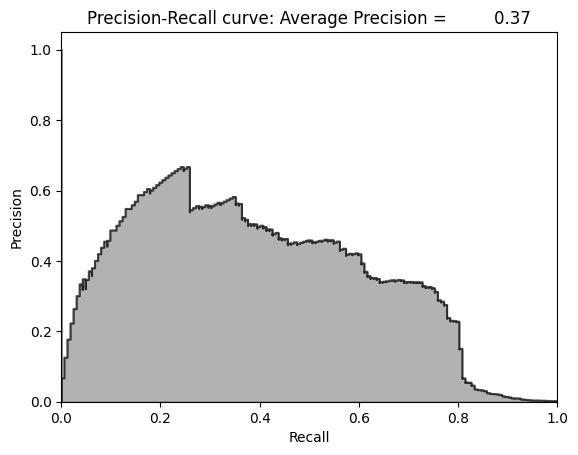

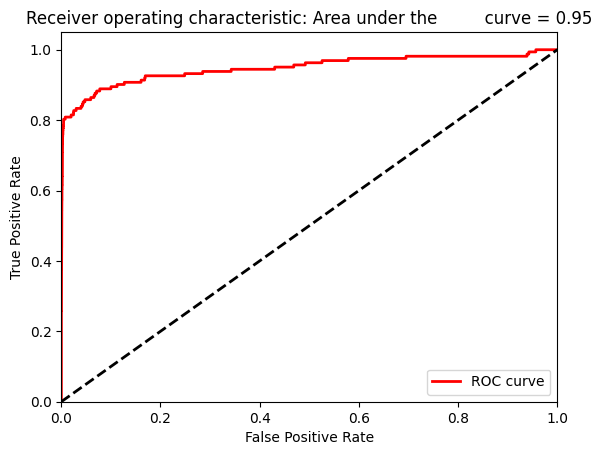

In [17]:
# 테스트 셋에 대한 평가
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()